In [1]:
from collections import defaultdict
from pathlib import Path

import colorcet as cc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63, solve_ode
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import NeuralODE
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot, plot_line_and_band
from ott.utils import batched_vmap
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

EXP_TYPES = ("vanilla", "jacobian", "neighborhood")
COLOR_DICT = dict(zip(EXP_TYPES, ("royalblue", "limegreen", "orangered")))
LABEL_DICT = dict(
    zip(EXP_TYPES, ("Vanilla", "Jacobian matching", "Neighborhood-based (ours)"))
)

In [2]:
downsample = 40
noise = 0.0
train_length = 2

datadir = Path("../../data")
loaddir = Path(f"../../results/lorenz63_{downsample=}/len={train_length}")

dataset_train, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large_test.hdf5")
    .add_noise(noise)
    .apply_transform(transform)
)


def load_experiment(exp_type: str, key: int) -> NeuralODE:
    match exp_type:
        case "vanilla":
            model = load_model(loaddir / f"lr=0.005_noise={noise}_key={key}.eqx")
        case "jacobian":
            model = load_model(loaddir / "jacobian" / f"noise={noise}_key={key}.eqx")
        case "neighborhood":
            model = load_model(
                loaddir
                / "neighborhood/weight=1.0"
                / f"lr=0.005_noise={noise}_key={key}.eqx"
            )
        case _:
            raise ValueError("Unsupported experiment type!")
    return model

In [7]:
key = 10
traj_idx = 100
t_traj, u_traj = dataset_test[traj_idx]

n_short = 750
t_short_norm = np.arange(n_short) * 0.01
t_short, u_short = t_traj[:n_short], u_traj[:n_short]

u_short_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    model = load_experiment(exp_type, key)
    u_short_dict[exp_type] = solve_ode(model, t_short, u_short[0], rtol=1e-4, atol=1e-6)

100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Text(0.5, 0.98, 'Short term predictions: train_length=2, seed=10')

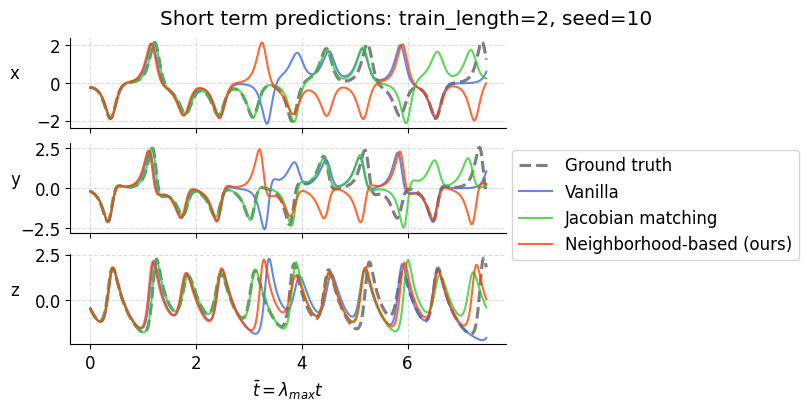

In [8]:
plot_kwargs = {"linewidth": 1.5, "alpha": 0.8}

fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
for i, (ax, y_name) in enumerate(zip(axes.flat, ("x", "y", "z"))):
    ax.plot(
        t_short_norm,
        u_short[:, i],
        "--",
        color="black",
        linewidth=2.25,
        alpha=0.5,
        label="Ground truth",
    )
    for exp_type, u_pred in u_short_dict.items():
        ax.plot(
            t_short_norm,
            u_pred[:, i],
            color=COLOR_DICT[exp_type],
            label=LABEL_DICT[exp_type],
            **plot_kwargs,
        )
    ax.set_ylabel(y_name, rotation="horizontal")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
fig.align_ylabels()
fig.legend(
    *ax.get_legend_handles_labels(), loc="outside center right", fontsize="medium"
)
fig.suptitle(f"Short term predictions: {train_length=}, seed={key}", fontsize="large")

In [10]:
@eqx.filter_jit
def solve_batch(model, t, u0_batch):
    def _solve(u0_):
        return solve_ode(model, t, u0_, rtol=1e-4, atol=1e-6, max_steps=None)

    return batched_vmap(_solve, batch_size=20000)(u0_batch)


@eqx.filter_jit
def calculate_metric_short(model, metric_fn=mean_squared_error):
    t_short = dataset_test.t[0, :n_short]
    u_short_batch = dataset_test.u[:, :n_short]

    u_pred_batch = solve_batch(model, t_short, u_short_batch[:, 0])
    return jnp.mean(metric_fn(u_short_batch, u_pred_batch, axis=-1), axis=0)


metric_short_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    metric_short_dict[exp_type] = [
        calculate_metric_short(load_experiment(exp_type, k)) for k in (0, 10, 20)
    ]


100%|██████████| 3/3 [00:24<00:00,  8.32s/it]


Text(0, 0.5, 'MSE (↓)')

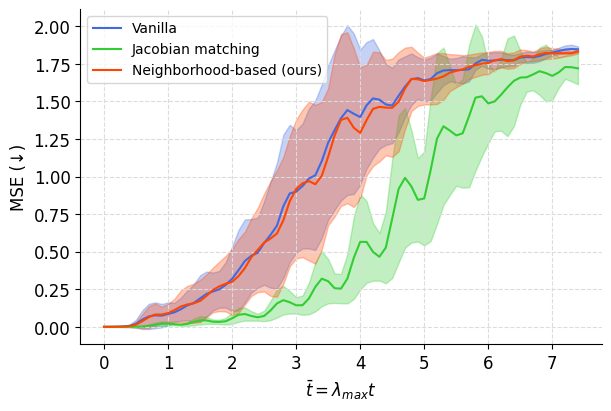

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for exp_type, metric_short in metric_short_dict.items():
    plot_line_and_band(
        ax,
        t_short_norm[::10],
        np.mean(metric_short, axis=0)[::10],
        np.std(metric_short, axis=0)[::10],
        color=COLOR_DICT[exp_type],
        label=LABEL_DICT[exp_type],
    )
ax.legend(fontsize="small")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
ax.set_ylabel("MSE (↓)")


In [14]:
idx_long = np.asarray([1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]) - 1
t_norm = np.arange(dataset_test.t.shape[0]) * 0.01
t_long, t_long_norm = dataset_test.t[0, idx_long], t_norm[idx_long]


def calculate_metric_long(model, metric_fn=jax.jit(sinkhorn_divergence)):
    u_long_batch = dataset_test.u[:, idx_long]
    u_long_pred = solve_batch(model, t_long, u_long_batch[:, 0])
    metric = []
    for i in range(1, len(idx_long)):
        metric.append(metric_fn(u_long_batch[:, i], u_long_pred[:, i]))
    return np.asarray(metric)


metric_long_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    metric_long_dict[exp_type] = [
        calculate_metric_long(load_experiment(exp_type, k)) for k in (0, 10, 20)
    ]


100%|██████████| 3/3 [06:41<00:00, 133.74s/it]


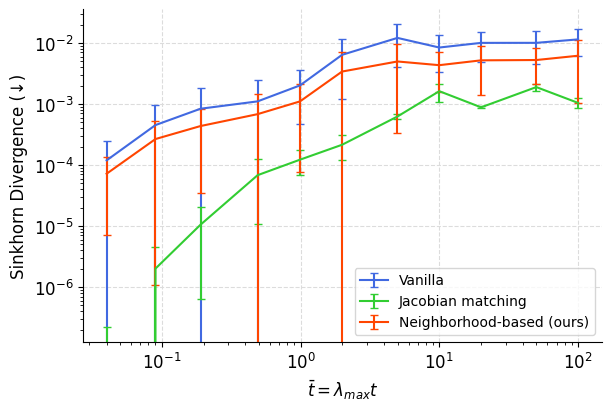

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for exp_type, metric_long in metric_long_dict.items():
    ax.errorbar(
        t_long_norm[1:],
        np.mean(metric_long, axis=0),
        np.std(metric_long, axis=0),
        capsize=3,
        color=COLOR_DICT[exp_type],
        label=LABEL_DICT[exp_type],
    )
ax.legend(fontsize="small")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
ax.set_ylabel("Sinkhorn Divergence (↓)")
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)

In [18]:
key = 20
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz63(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


jac_logerr_dict = defaultdict(list)
for exp_type in tqdm(EXP_TYPES):
    jac_logerr_dict[exp_type] = np.log10(
        compute_jac_err(load_experiment(exp_type, key))
    )


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Text(0, 0.5, '$\\log_{10}||\\mathbf{J}_{true}-\\mathbf{J}_{pred}||_F\\;/\\;||\\mathbf{J}_{true}||_F$')

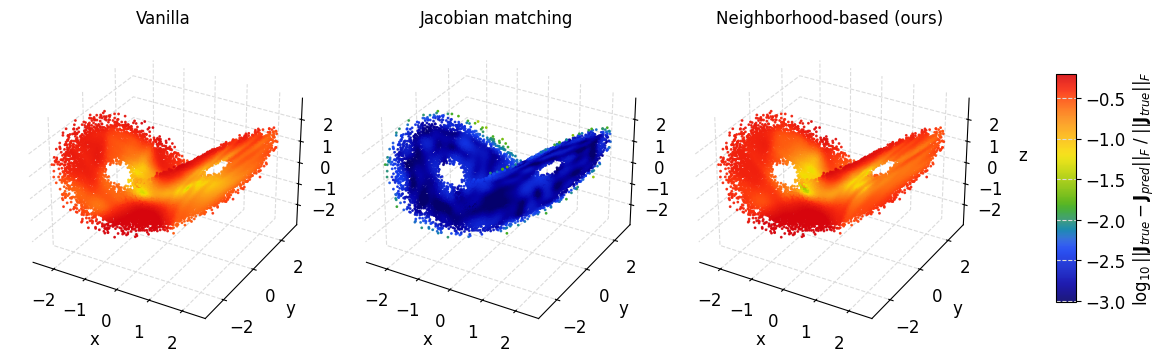

In [19]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0].T] * len(EXP_TYPES),
    [jac_logerr_dict[exp_type] for exp_type in EXP_TYPES],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)
for i, exp_type in enumerate(EXP_TYPES):
    fig.axes[i].set_title(LABEL_DICT[exp_type], fontsize="medium")
    set_labels(fig.axes[i], ["x", "y", "z"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)

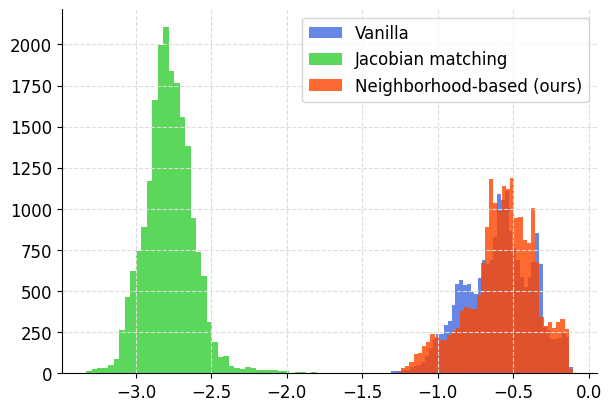

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for exp_type, log_err in jac_logerr_dict.items():
    ax.hist(
        log_err,
        bins=50,
        label=LABEL_DICT[exp_type],
        color=COLOR_DICT[exp_type],
        alpha=0.8,
    )
ax.legend()